In [26]:
import pandas as pd
import numpy as np
import pickle

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import linear_model as lm, metrics, tree, ensemble, model_selection as ms, feature_selection, svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

%matplotlib inline 

pd.options.mode.chained_assignment = None 

np.random.seed(42)

import warnings
warnings.filterwarnings("ignore")

In [33]:
sns.set(rc={
    'figure.figsize': (12, 8),
    'font.size': 14
})

# Set palette
sns.set_palette("husl")

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 5000)

In [28]:
data = pd.read_csv('ml_imdb_data.csv')
data.drop(columns = data.columns[0],inplace=True)

In [29]:
certificates = data['Certificate'].unique()
certificates = certificates.tolist()
tmp_num = [x for x in range(18)]
data['Certificate'] = data['Certificate'].apply(lambda x: int(tmp_num[certificates.index(x)]))

In [30]:
metascore_mean = data['Metascore'].mean()
data['Metascore'].fillna(value = metascore_mean, inplace= True)
gross_mean = data['Gross'].mean()
data['Gross'].fillna(value= gross_mean, inplace= True)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17483 entries, 0 to 17482
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Title           17483 non-null  int64  
 1   Year            17483 non-null  int64  
 2   Certificate     17483 non-null  int64  
 3   Rating          17483 non-null  float64
 4   Metascore       17483 non-null  float64
 5   Votes           17483 non-null  int64  
 6   Gross           17483 non-null  float64
 7   Movie_time_min  17483 non-null  int64  
 8   History         17483 non-null  int64  
 9   Biography       17483 non-null  int64  
 10  Horror          17483 non-null  int64  
 11  Adventure       17483 non-null  int64  
 12  Animation       17483 non-null  int64  
 13  Sport           17483 non-null  int64  
 14  Thriller        17483 non-null  int64  
 15  Drama           17483 non-null  int64  
 16  Western         17483 non-null  int64  
 17  Action          17483 non-null 

In [32]:
data.head()

,Title,Year,Certificate,Rating,Metascore,Votes,Gross,Movie_time_min,History,Biography,Horror,Adventure,Animation,Sport,Thriller,Drama,Western,Action,Mystery,Music,Romance,Film-Noir,War,Comedy,Family,Musical,Sci-Fi,Fantasy,Crime
0,15,2008,0,9.0,84.000000,2428474,5.348584e+08,152,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
1,45,2003,0,8.9,94.000000,1715249,3.778459e+08,201,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,9,2010,0,8.8,74.000000,2179206,2.925762e+08,148,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,49,2001,0,8.8,92.000000,1736538,3.155448e+08,178,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
4,15,2016,1,8.7,73.967558,106888,5.749955e+07,135,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0


Text(0, 0.5, 'Rating')

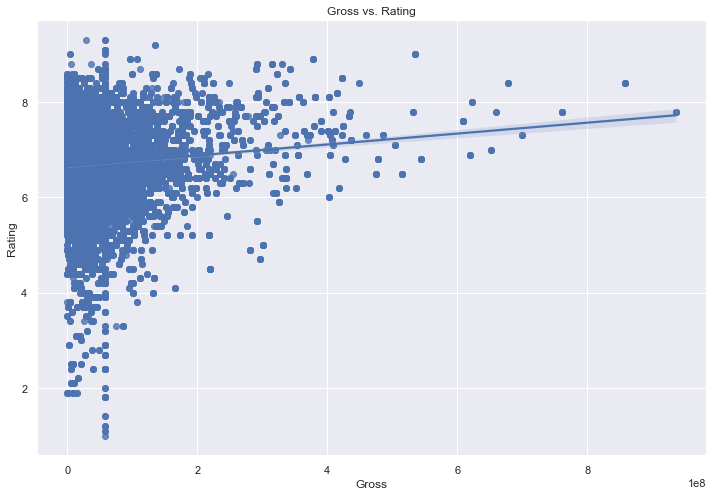

In [36]:
sns.regplot(x='Gross', y = 'Rating', data = data, color = 'b')
plt.title('Gross vs. Rating')
plt.xlabel('Gross')
plt.ylabel('Rating')

Text(0, 0.5, 'Rating')

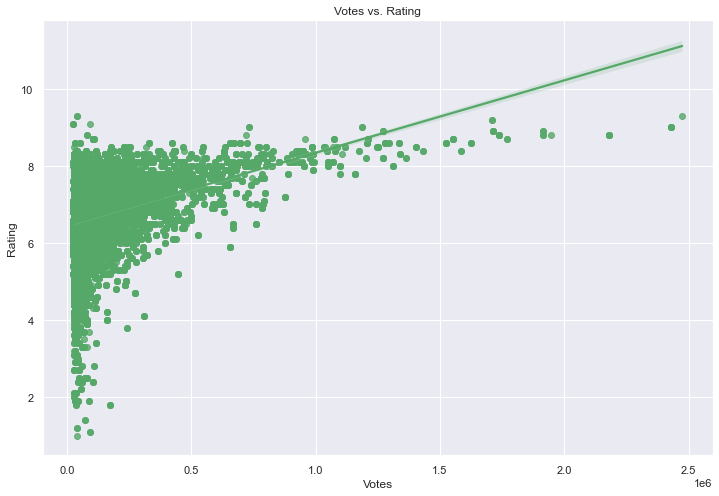

In [37]:
sns.regplot(x='Votes', y = 'Rating', data = data, color = 'g')
plt.title('Votes vs. Rating')
plt.xlabel('Votes')
plt.ylabel('Rating')

In [38]:
X = data.drop(['Rating'], axis = 1)
y = data.Rating

In [41]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.3, random_state=42)
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
print("Length of training sets:",len(X_train), len(X_test))
print("Length of testing sets:",len(y_train), len(y_test))

Length of training sets: 12238 5245
Length of testing sets: 12238 5245


In [43]:
y_pred_mean = [y_train.mean()] * len(y_test)
print("Baseline score RMSE: ",'{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_mean))))

Baseline score RMSE:  0.95


In [46]:
# Function to return simple model metrics
def get_model_metrics(X_train, y_train, X_test, y_test, model, parametric=True):
    """This function takes the train-test splits as arguments, as well as the algorithm 
    being used, and returns the training score, the test score (both RMSE), the 
    cross-validated scores and the mean cross-validated score. It also returns the appropriate 
    feature importances depending on whether the optional argument 'parametric' is equal to 
    True or False."""
    
    model.fit(X_train, y_train)
    train_pred = np.around(model.predict(X_train),1)
    test_pred = np.around(model.predict(X_test),1)
    
    print('Training score', '{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train, train_pred))))
    print('Testing RMSE:', '{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, test_pred))))
    cv_scores = -ms.cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print('Cross-validated RMSEs:', np.sqrt(cv_scores))
    print('Mean cross-validated RMSE:', '{0:0.2f}'.format(np.sqrt(np.mean(cv_scores))))
    
    if parametric == True:
        print(pd.DataFrame(list(zip(X_train.columns, model.coef_, abs(model.coef_))), 
                 columns=['Feature', 'Coef', 'Abs Coef']).sort_values('Abs Coef', ascending=False).head(10))
    else:
        print(pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)), 
                 columns=['Feature', 'Importance']).sort_values('Importance', ascending=False).head(10))
    
    return model

In [65]:
# Function to return regularised model metrics
def regularised_model_metrics(X_train, y_train, X_test, y_test, model, grid_params, parametric=True):
    """This function takes the train-test splits as arguments, as well as the algorithm being 
    used and the parameters, and returns the best cross-validated training score, the test 
    score, the best performing model and it's parameters, and the feature importances."""
    
    gridsearch = GridSearchCV(model,
                              grid_params,
                              n_jobs=-1, cv=5, verbose=1, error_score='raise')
    
    gridsearch.fit(X_train, y_train)
    print('Best parameters:', gridsearch.best_params_)
    print('Cross-validated score on test data:', '{0:0.2f}'.format(abs(gridsearch.best_score_)))
    best_model = gridsearch.best_estimator_
    print('Testing RMSE:', '{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, best_model.predict(X_test)))))
    
    if parametric == True:
        print(pd.DataFrame(list(zip(X_train.columns, best_model.coef_, abs(best_model.coef_))), 
                 columns=['Feature', 'Coef', 'Abs Coef']).sort_values('Abs Coef', ascending=False).head(10))
    else:
        print(pd.DataFrame(list(zip(X_train.columns, best_model.feature_importances_)), 
                 columns=['Feature', 'Importance']).sort_values('Importance', ascending=False).head(10))
    
    return best_model

In [48]:
#Linear Regression Simple

lm_simple = get_model_metrics(X_train, y_train, X_test, y_test, lm.LinearRegression())
lm_simple

Training score 0.71
Testing RMSE: 0.72
Cross-validated RMSEs: [0.73489996 0.73796347 0.70788727 0.69476109 0.68854527]
Mean cross-validated RMSE: 0.71
           Feature      Coef  Abs Coef
4            Votes  0.388784  0.388784
1             Year -0.220900  0.220900
6   Movie_time_min  0.186293  0.186293
11       Animation  0.172037  0.172037
14           Drama  0.154945  0.154945
9           Horror -0.112485  0.112485
16          Action -0.108984  0.108984
2      Certificate  0.103585  0.103585
23          Family -0.092098  0.092098
5            Gross -0.091351  0.091351


LinearRegression()

In [72]:
ridge = lm.Ridge()
list(ridge.get_params())

['alpha',
 'copy_X',
 'fit_intercept',
 'max_iter',
 'normalize',
 'positive',
 'random_state',
 'solver',
 'tol']

In [73]:
ridge_params = {'alpha': np.logspace(-10, 10, 10),
               'fit_intercept': [True, False],
               'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

ridge_model = regularised_model_metrics(X_train, y_train, X_test, y_test, ridge, ridge_params)

Fitting 5 folds for each of 140 candidates, totalling 700 fits
Best parameters: {'alpha': 12.915496650148826, 'fit_intercept': True, 'solver': 'sag'}
Cross-validated score on test data: 0.44
Testing RMSE: 0.72
           Feature      Coef  Abs Coef
4            Votes  0.388135  0.388135
1             Year -0.220731  0.220731
6   Movie_time_min  0.186171  0.186171
11       Animation  0.171761  0.171761
14           Drama  0.155241  0.155241
9           Horror -0.112257  0.112257
16          Action -0.108935  0.108935
2      Certificate  0.103621  0.103621
23          Family -0.091791  0.091791
5            Gross -0.090748  0.090748


In [74]:
lasso = lm.Lasso()
list(lasso.get_params())

['alpha',
 'copy_X',
 'fit_intercept',
 'max_iter',
 'normalize',
 'positive',
 'precompute',
 'random_state',
 'selection',
 'tol',
 'warm_start']

In [75]:
lasso_params = {'alpha': np.logspace(-10, 10, 10),
               'fit_intercept': [True, False]}

lasso_model = regularised_model_metrics(X_train, y_train, X_test, y_test, lasso, lasso_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'alpha': 0.0004641588833612782, 'fit_intercept': True}
Cross-validated score on test data: 0.44
Testing RMSE: 0.72
           Feature      Coef  Abs Coef
4            Votes  0.388001  0.388001
1             Year -0.220771  0.220771
6   Movie_time_min  0.185599  0.185599
11       Animation  0.172841  0.172841
14           Drama  0.158208  0.158208
9           Horror -0.109878  0.109878
16          Action -0.105991  0.105991
2      Certificate  0.103436  0.103436
5            Gross -0.090316  0.090316
23          Family -0.090247  0.090247


In [57]:
elastic = lm.ElasticNet()
list(elastic.get_params())

['alpha',
 'copy_X',
 'fit_intercept',
 'l1_ratio',
 'max_iter',
 'normalize',
 'positive',
 'precompute',
 'random_state',
 'selection',
 'tol',
 'warm_start']

In [66]:
elastic_params = {'alpha': np.logspace(-10, 10, 10),
                 'l1_ratio': np.linspace(0.05, 0.95, 10),
                 'fit_intercept': [True, False]}

elastic_model = regularised_model_metrics(X_train, y_train, X_test, y_test, elastic, 
                                          elastic_params)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameters: {'alpha': 0.0004641588833612782, 'fit_intercept': True, 'l1_ratio': 0.95}
Cross-validated score on test data: 0.44
Testing RMSE: 0.72
           Feature      Coef  Abs Coef
4            Votes  0.388025  0.388025
1             Year -0.220771  0.220771
6   Movie_time_min  0.185629  0.185629
11       Animation  0.172793  0.172793
14           Drama  0.158045  0.158045
9           Horror -0.110005  0.110005
16          Action -0.106138  0.106138
2      Certificate  0.103444  0.103444
5            Gross -0.090356  0.090356
23          Family -0.090337  0.090337


In [59]:
dt = get_model_metrics(X_train, y_train, X_test, y_test, tree.DecisionTreeRegressor(), 
                       parametric=False)
dt

Training score 0.00
Testing RMSE: 0.32
Cross-validated RMSEs: [0.41418871 0.40382161 0.40091297 0.39547399 0.35030491]
Mean cross-validated RMSE: 0.39
           Feature  Importance
3        Metascore    0.311300
4            Votes    0.156335
1             Year    0.111837
6   Movie_time_min    0.091369
5            Gross    0.073775
2      Certificate    0.052936
14           Drama    0.051866
0            Title    0.047259
11       Animation    0.015824
27           Crime    0.008859


DecisionTreeRegressor()

In [60]:
rf = get_model_metrics(X_train, y_train, X_test, y_test, ensemble.RandomForestRegressor(), 
                       parametric=False)
rf

Training score 0.10
Testing RMSE: 0.27
Cross-validated RMSEs: [0.34722879 0.33329252 0.3199476  0.30755815 0.2667292 ]
Mean cross-validated RMSE: 0.32
           Feature  Importance
3        Metascore    0.311667
4            Votes    0.144022
1             Year    0.111142
6   Movie_time_min    0.100723
5            Gross    0.079162
2      Certificate    0.053572
0            Title    0.050338
14           Drama    0.042900
11       Animation    0.012323
16          Action    0.011797


RandomForestRegressor()

In [61]:
rrf = ensemble.RandomForestRegressor()
list(rrf.get_params())

['bootstrap',
 'ccp_alpha',
 'criterion',
 'max_depth',
 'max_features',
 'max_leaf_nodes',
 'max_samples',
 'min_impurity_decrease',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'n_estimators',
 'n_jobs',
 'oob_score',
 'random_state',
 'verbose',
 'warm_start']

In [67]:
rrf_params = {'bootstrap': [True, False],
             'max_depth': np.linspace(5, 50, 5),
             'min_samples_split': np.linspace(0.01, 1, 5),
             'n_estimators': [40, 50, 60]}

rrf_model = regularised_model_metrics(X_train, y_train, X_test, y_test, rrf, rrf_params,
                                     parametric=False)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best parameters: {'bootstrap': True, 'max_depth': 27.5, 'min_samples_split': 0.01, 'n_estimators': 60}
Cross-validated score on test data: 0.66
Testing RMSE: 0.56
           Feature  Importance
3        Metascore    0.461118
4            Votes    0.129798
1             Year    0.094962
6   Movie_time_min    0.079335
14           Drama    0.063891
2      Certificate    0.051662
5            Gross    0.043606
0            Title    0.017355
11       Animation    0.016827
9           Horror    0.007312


In [63]:
bagdt = ensemble.BaggingRegressor()
bagdt.fit(X_train, y_train)

print('Training RMSE:', '{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train, bagdt.predict(X_train)))))
print('Testing RMSE:', '{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, bagdt.predict(X_test)))))
cv_scores = -ms.cross_val_score(bagdt, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print('Cross-validated RMSEs:', cv_scores)
print('Mean cross-validated RMSE:', '{0:0.2f}'.format(np.mean(cv_scores)))

Training RMSE: 0.12
Testing RMSE: 0.29
Cross-validated RMSEs: [0.14213199 0.12472986 0.12163268 0.1059772  0.09203547]
Mean cross-validated RMSE: 0.12


In [68]:
lin = svm.LinearSVR() 

lin_params = {
    'C': np.logspace(-3, 2, 5),
    'loss': ['epsilon_insensitive','squared_epsilon_insensitive'],
    'fit_intercept': [True,False],
    'max_iter': [1000]
}

lin_model = regularised_model_metrics(X_train, y_train, X_test, y_test, lin, lin_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/homebrew/Caskroom/miniforge/base/envs/cenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cenv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

Best parameters: {'C': 0.31622776601683794, 'fit_intercept': True, 'loss': 'squared_epsilon_insensitive', 'max_iter': 1000}
Cross-validated score on test data: 0.44
Testing RMSE: 0.72
           Feature      Coef  Abs Coef
4            Votes  0.388762  0.388762
1             Year -0.220858  0.220858
6   Movie_time_min  0.186255  0.186255
11       Animation  0.172003  0.172003
14           Drama  0.154948  0.154948
9           Horror -0.112464  0.112464
16          Action -0.108963  0.108963
2      Certificate  0.103585  0.103585
23          Family -0.092071  0.092071
5            Gross -0.091306  0.091306


In [70]:
rbf = svm.SVR(kernel='rbf')

rbf_params = {
    'C': np.logspace(-3, 3, 5),
    'gamma': np.logspace(-4, 1, 5),
    'kernel': ['rbf']}

rbf = GridSearchCV(rbf, rbf_params, n_jobs=-1, cv=5, verbose=1, error_score='raise')
rbf.fit(X_train, y_train)
print('Best parameters:', rbf.best_params_)
print('Cross-validated Training RMSE:', '{0:0.2f}'.format(abs(rbf.best_score_)))
print('Testing RMSE:', '{0:0.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, rbf.best_estimator_.predict(X_test)))))


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'C': 31.622776601683793, 'gamma': 0.5623413251903491, 'kernel': 'rbf'}
Cross-validated Training RMSE: 0.83
Testing RMSE: 0.32


In [77]:
poly = svm.SVR(kernel='poly', C = 1, gamma = 0.1)

poly.fit(X_train,y_train)


SVR(C=1, gamma=0.1, kernel='poly')

In [79]:
pred = poly.predict(X_test)

In [86]:
score = poly.score(X_train,y_train)
print('R-squared:', score)
print('MSE:', metrics.mean_squared_error(y_test, pred))

R-squared: 0.6893435675879827
MSE: 0.3910171284215583
